<a href="https://colab.research.google.com/github/pattaradanai-lks/DADS5001/blob/main/6610412011_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pandas
!pip install numpy
!pip install requests
!pip install lxml
!pip install yfinance

In [4]:
import yfinance as yf
df = yf.download('NKE', start='2022-07-01', end='2023-12-12',interval='1h')
df = df.dropna()
df = df.iloc[:,:4]


[*********************100%%**********************]  1 of 1 completed


In [5]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4496    0  4496    0     0  10806      0 --:--:-- --:--:-- --:--:-- 10807
100  517k  100  517k    0     0   547k      0 --:--:-- --:--:-- --:--:--  547k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4468    0  4468    0     0  19385      0 --:--:-- --:--:-- --:--:-- 19341
100  392k  100  392k    0     0   796k      0 --:--:-- --:--:-- --:--:--  796k


In [6]:
# Data Manipulation
import numpy as np
import pandas as pd

# Technical Indicators
import talib as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Data fetching
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [7]:
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X = df.iloc[:,:9]

In [8]:

# ดึงข้อมูลการซื้อขายของ IBM ในช่วงเวลาที่ตรงกับ X
df_ibm = yf.download('IBM', start='2022-07-28', end='2023-12-10',interval='1h')
df_ibm = df_ibm.dropna()

# คำนวณ Corr ของ IBM
df_ibm['S_10'] = df_ibm['Close'].rolling(window=10).mean()
df_ibm['Corr_IBM'] = df_ibm['Close'].rolling(window=10).corr(df_ibm['S_10'])

# เลือกเฉพาะคอลัมน์ที่ต้องการจะนำมาใช้
df_ibm = df_ibm[['Corr_IBM']]

# รวม DataFrame X และ RSI ของ IBM เข้าด้วยกัน
X2 = pd.concat([X, df_ibm], axis=1)

# แทน NaN ในคอลัมน์ 'RSI_IBM' ด้วย 0
X2['Corr_IBM'] = X2['Corr_IBM'].fillna(0)

[*********************100%%**********************]  1 of 1 completed


In [9]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)
split = int(0.8*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [10]:
# สร้างตัวแปรตามโค้ดก่อนหน้า
y2 = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
split2 = int(0.8 * len(df))
X_train2, X_test2, y_train2, y_test2 = X2[:split2], X2[split2:], y2[:split2], y2[split2:]

# ทำ Standardization ของข้อมูล
scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train2)
X_test_scaled2 = scaler2.transform(X_test2)

# สร้างและฝึกโมเดล
model2 = LogisticRegression()
model2.fit(X_train_scaled2, y_train2)


LogisticRegression()

In [11]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Open,[0.201704187083897]
1,High,[0.4260966425957307]
2,Low,[0.06666387511004045]
3,Close,[-0.051604353377729055]
4,S_10,[-0.6309449688886618]
5,Corr,[-0.024825274748405967]
6,RSI,[0.003807822217700807]
7,Open-Close,[0.012216926031701679]
8,Open-Open,[-0.05205294451547118]


In [12]:
pd.DataFrame(zip(X2.columns, np.transpose(model2.coef_)))

,0,1
0,Open,[0.20868500787806746]
1,High,[0.43219268327482613]
2,Low,[0.043496715196718286]
3,Close,[-0.03155552976885387]
4,S_10,[-0.643218425526361]
5,Corr,[-0.022301254844211707]
6,RSI,[0.0009159007343622867]
7,Open-Close,[0.012515396458300587]
8,Open-Open,[-0.051855707277344044]
9,Corr_IBM,[-0.02891374128633434]


In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

probability = model.predict_proba(X_test)
print(probability)

[[0.07736602 0.92263398]
 [0.09186069 0.90813931]
 [0.09932498 0.90067502]
 ...
 [0.06071585 0.93928415]
 [0.07599994 0.92400006]
 [0.10616622 0.89383378]]


In [14]:
probability2 = model2.predict_proba(X_test_scaled2)
print(probability2)

[[0.48903502 0.51096498]
 [0.4775139  0.5224861 ]
 [0.48756984 0.51243016]
 ...
 [0.47548729 0.52451271]
 [0.47703085 0.52296915]
 [0.4817519  0.5182481 ]]


In [15]:
predicted = model.predict(X_test)
print(metrics.confusion_matrix(y_test, predicted))

[[  0 254]
 [  1 249]]


In [16]:
predicted2 = model2.predict(X_test_scaled2)
conf_matrix2 = metrics.confusion_matrix(y_test2, predicted2)
print(conf_matrix2)


[[124 130]
 [100 150]]


In [17]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       254
           1       0.50      1.00      0.66       250

    accuracy                           0.49       504
   macro avg       0.25      0.50      0.33       504
weighted avg       0.25      0.49      0.33       504



In [18]:
print(metrics.classification_report(y_test2, predicted2))

              precision    recall  f1-score   support

          -1       0.55      0.49      0.52       254
           1       0.54      0.60      0.57       250

    accuracy                           0.54       504
   macro avg       0.54      0.54      0.54       504
weighted avg       0.54      0.54      0.54       504



In [19]:
print(model.score(X_test,y_test))

0.49404761904761907


In [20]:
print(model2.score(X_test_scaled2, y_test2))

0.5436507936507936


In [21]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.52777778 0.49206349 0.47222222 0.52777778 0.48015873 0.53968254
 0.46825397 0.48015873 0.53386454 0.50996016]
0.5031919939290457


In [22]:
cross_val2 = cross_val_score(LogisticRegression(), X2, y, scoring='accuracy', cv=10)
print(cross_val2)
print(cross_val2.mean())


[0.5515873  0.50793651 0.5        0.51587302 0.46825397 0.51984127
 0.47222222 0.5        0.56175299 0.55776892]
0.5155236198064882


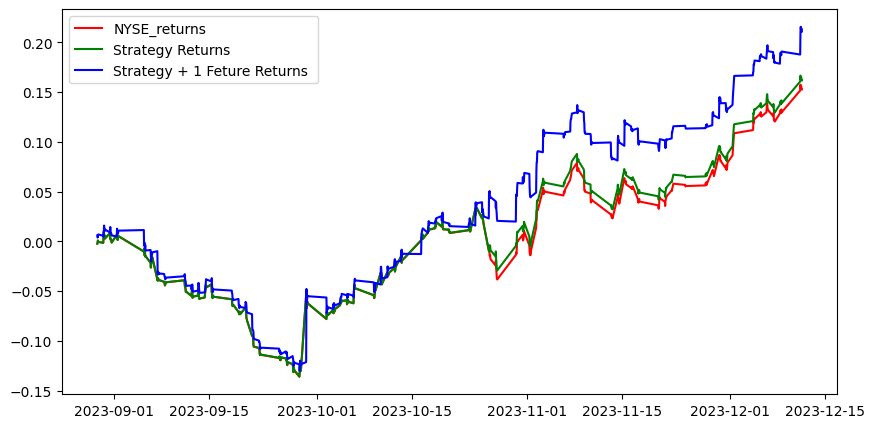

In [23]:
df['NYSE_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_NYSE_returns = np.cumsum(df[split:]['NYSE_returns'])

# ทำนายสัญญาณบน X
df['Predicted_Signal'] = model.predict(X)
df['Strategy_returns'] = df['NYSE_returns'].shift(1) * df['Predicted_Signal']
# ทำนายสัญญาณบน X2
df['Predicted_Signal_X2'] = model2.predict(X2)
df['Strategy_returns_X2'] = df['NYSE_returns'] * df['Predicted_Signal_X2'].shift(1)

Cumulative_Strategy_returns_X2 = np.cumsum(df[split:]['Strategy_returns'])
Cumulative_Strategy_returns = np.cumsum(df[split:]['Strategy_returns_X2'])

# แสดงผลลัพธ์
plt.figure(figsize=(10, 5))
plt.plot(Cumulative_NYSE_returns, color='r', label='NYSE_returns')
plt.plot(Cumulative_Strategy_returns, color='g', label='Strategy Returns')
plt.plot(Cumulative_Strategy_returns_X2, color='b', label='Strategy + 1 Feture Returns ')
plt.legend()
plt.show()
